# Project: Markets from Tax Data

* Objective: Help businesses find economically favorable locations.
* How? The IRS supplies personal income tax statistics organized by zipcode. Analyze it!

## Import modules  and data

In [5]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
sns.set(context = 'notebook', font_scale = 1.5, rc={'figure.figsize':(10, 6)})

In [2]:
def import_data(years):
    '''
    Import tax data into a dictionary of pandas Dataframes
    '''
    labels = {'n1': 'num_returns','n2' : 'num_exemp', 'a00100' : 'agi'}
    tax_data = {}
    for year in years:
        tax_data[year] = pd.read_csv('../Data Incubator/20'+year+'zipcode/'+year+'zpallagi.csv',na_values=['.'])
        tax_data[year].columns = [x.lower() for x in tax_data[year].columns]
        tax_data[year].rename(columns = labels, inplace = True)
    return tax_data

In [3]:
YEARS = [str(i).zfill(2) for i in xrange(5,16)]
tax_data = import_data(YEARS)
tax_data['12'].head()

/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,statefips,state,zipcode,agi_stub,num_returns,mars1,mars2,mars4,prep,num_exemp,...,n09600,a09600,n06500,a06500,n10300,a10300,n11901,a11901,n11902,a11902
0,1,AL,0,1,889920.0,490850.0,129070.0,256900.0,526740.0,1505430.0,...,0.0,0.0,269140.0,168057.0,387720.0,314297.0,59310.0,40782.0,785950.0,2040191.0
1,1,AL,0,2,491150.0,194370.0,159200.0,123350.0,293480.0,1034650.0,...,0.0,0.0,370140.0,854669.0,389320.0,937609.0,62450.0,85568.0,421290.0,1185415.0
2,1,AL,0,3,254280.0,68160.0,148960.0,31480.0,157230.0,591880.0,...,100.0,73.0,242260.0,1214154.0,245280.0,1286668.0,55290.0,113674.0,193020.0,550512.0
3,1,AL,0,4,160160.0,23020.0,126140.0,9030.0,97620.0,420830.0,...,260.0,318.0,158560.0,1281451.0,158980.0,1342424.0,38890.0,104526.0,116570.0,388708.0
4,1,AL,0,5,183320.0,15880.0,161260.0,4890.0,110520.0,517060.0,...,2350.0,4924.0,182620.0,3193351.0,182800.0,3319526.0,66910.0,323614.0,108270.0,430314.0


## Data Cleaning

In [4]:
'''
def find_agi_data(years, division = 'state'):
    agi_data = {}
    for year in YEARS:
        agi_data[year] = tax_data[year][['state','zipcode', 'agi', 'num_returns', 'num_exemp']].groupby(['state', 'zipcode'],as_index=False).sum().copy()
        agi_data[year] = agi_data[year][agi_data[year]['num_returns']>250]
        agi_data[year] = agi_data[year][agi_data[year]['zipcode']>0]
        agi_data[year]['state'] = map(lambda x: x.upper(), agi_data[year]['state'])
        agi_data[year] = agi_data[year][[division, 'agi', 'num_returns', 'num_exemp']].groupby(division,as_index=False).sum().copy()
        labels = {'num_returns':'num_returns'+year, 'num_exemp':'num_exemp'+year, 'agi':'agi'+year}
        agi_data[year].rename(columns = labels, inplace = True)
        if year in ['07','08']:
            agi_data[year]['agi'+year] = agi_data[year]['agi'+year]/1000
    return reduce(lambda left,right: pd.merge(left,right,on=division), [agi_data[year] for year in YEARS])
agi_data = find_agi_data(YEARS, 'state')    
'''

In [34]:
def features_lists():
    number_features = {}
    amount_features = {}
    for year in YEARS:
        all_features = list(tax_data[year].columns.values)
        number_features[year] = [feat for feat in ['mars1', 'mars2', 'mars4', 'prep', 'numdep', 'schf', 'num_exemp']\
                          if feat in all_features]
        amount_features[year] = []
        for col in all_features:
            try:
                int(col[1:]) #throws an exception unless we are accessing one of the features we want
                if col[0] == 'a':
                    amount_features[year].append(col)
                elif col[0]== 'n':
                    number_features[year].append(col)
            except ValueError:
                pass
    return number_features, amount_features

In [124]:
def normalize_features(division = 'zipcode', income_level = 'all'):
    '''
    Returns a DataFrame where the data has been 
    '''
    upper_limit = 10
    lower_limit = 0
    if income_level == 'low':
        upper_limit = 3
    if income_level == 'mid':
        lower_limit = 2
        upper_limit = 5
    if income_level == 'high':
        lower_limit = 4
    
    normalized_data = {}
    for year in YEARS:
        normalized_data[year] = tax_data[year].copy()
        normalized_data[year]['state'] = map(lambda x: x.upper(), normalized_data[year]['state'])
        normalized_data[year].rename(columns = {'agi_class':'agi_stub'}, inplace = True)
        income_conditions = (normalized_data[year].agi_stub < upper_limit) & (normalized_data[year].agi_stub > lower_limit)
        normalized_data[year] = normalized_data[year][income_conditions]
        normalized_data[year] = normalized_data[year].groupby(division).sum()
        if year in ['07','08']:
            normalized_data[year]['agi'] = normalized_data[year]['agi']/1000.
        normalized_data[year]['agi_per_exemp'] = normalized_data[year].agi/normalized_data[year].num_exemp
        normalized_data[year]['agi_per_return'] = normalized_data[year].agi/normalized_data[year].num_returns
        for col in N_FEATURES[year]:
            normalized_data[year][col] = normalized_data[year][col]/normalized_data[year].num_returns
        for col in A_FEATURES[year]:
            normalized_data[year][col] = normalized_data[year][col]/normalized_data[year].agi
        #normalized_data[year] = normalized_data[year].dropna()
    return normalized_data

In [39]:
def drop_features():
    bad_features = ['statefips','zipcode', 'agi_stub' ,'a05800', 'a04800', 'n04800', 'n05800', 'a06500', 'n06500',\
            'a10300', 'n10300', 'a11902', 'n11902', 'a10600', 'n10600', 'a59660', 'n59660', 'a59720', 'n59720',\
                  'n11070', 'a11070', 'a07220', 'n07220', 'a02650', 'n02650', 'a00101','agi_per_exemp']
    for year in YEARS: 
        all_features = list(normalized_data[year].columns.values)
        dropped = [feat for feat in bad_features if feat in all_features]
        normalized_data[year]=normalized_data[year].drop(dropped,axis=1)
def rename_columns():
    labels = {'n00200': '% w/ Wages','a00200': 'Wages/AGI','n85300':'% w/ Investments', 'mARS2' : '% Joint', \
          'a07100': 'Total Credits/AGI' , 'a04470':'Itemized Deductions/AGI', 'num_exemp':'Exemptions per Return',\
         'mars1': '% Single','a85300' : 'Investment Income/AGI', 'a02500':'SS Benefits/AGI', 'n26270':'% w/ S-corp',\
         'agi_per_exemp':'AGI/Exemption', 'NUMDEP':'Dependents/Return'}
    for year in YEARS:        
        normalized_data[year].rename(columns = labels, inplace = True)

In [128]:
%%time
N_FEATURES, A_FEATURES = features_lists()
INCOME_LEVEL = 'all'
DIVISION = 'state'
if DIVISION == 'state':
    NUM_DIV = 7759
else:
    NUM_DIV = 51
normalized_data = normalize_features(DIVISION, INCOME_LEVEL)
drop_features()
normalized_data['07'].head()

CPU times: user 4.55 s, sys: 2.43 s, total: 6.98 s
Wall time: 7.31 s


## Scratch Work

In [6]:
inflation_rate = {'05':3.42,'06':2.54,'07':4.08,\
                  '08':0.09,'09':2.72,'10':1.50,'11':2.96,\
                 '12':1.74,'13':1.50,'14':0.76}

In [18]:
for i in xrange(len(years)-1):
    agi_data['growth'+years[i]+years[i+1]] = agi_data['agi'+years[i+1]]/agi_data['agi'+years[i]] - 1 - inflation_rate[years[i+1]]/100
growth_list = ['growth'+years[i]+years[i+1] for i in xrange(len(years)-1)]
agi_data['growth_coef'] = agi_data[growth_list].mean(axis=1)
agi_data.head()

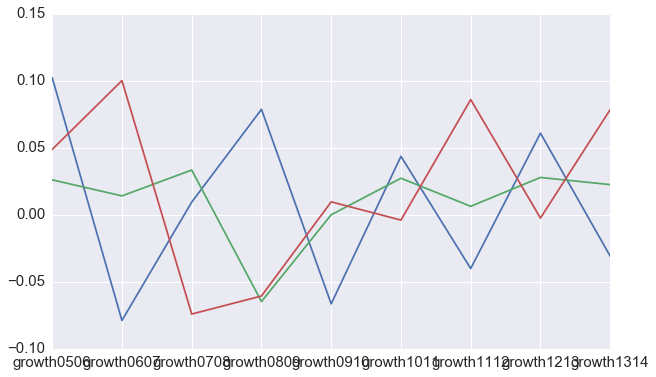

In [30]:
rand_rows = [np.random.randint(1,50) for i in xrange(3)]
growth_list = ['growth'+years[i]+years[i+1] for i in xrange(len(years)-1)]
for row in rand_rows:
    agi_data[growth_list].iloc[row].plot()

In [28]:
#agi_data.to_csv('agi_data')

In [31]:
def make_translator():
    states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
    }
    abbr_translator = {}
    for state in states:
        abbr_translator[states[state]] = state
        abbr_translator[state] = states[state]
    return abbr_translator

In [32]:
def toggle_abbr(states):
    return map(lambda x: abbr_translator[x], state_list)

In [33]:
state_list = toggle_abbr(state_list)

NameError: name 'state_list' is not defined

In [ ]:
import itertools

# define the color palette
ncolors = 5
palette = sns.palettes.color_palette('colorblind', ncolors)
# as hex is necessary for bokeh to render the colors properly.
colors = itertools.cycle(palette.as_hex())

plot = figure(plot_width=400, plot_height=400,\
             title = 'Total Adjusted Gross Income',
             x_axis_label = 'Year',
             y_axis_label = 'AGI ($ millions)')


for state, color in itertools.izip(toggle_abbr(state_list), colors):
    plot.line([5,6,7,8,9,10,11,12,13,14],plot_data.loc[state]/10**6,line_width=3,legend = state,line_color = color)
show(plot)

In [69]:
def histos(year=14):
    
    year_str = str(year).zfill(2)
    
    p1 = figure(title="Adjusted Gross Income Histogram for 20"+year_str)

    hist_data = np.log(agi_data['agi'+year_str])/np.log(10)

    hist, edges = np.histogram(hist_data, density=False, bins=50)

    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#033649")

    p1.xaxis.axis_label = 'Log_10 AGI'
    p1.yaxis.axis_label = 'Number of Zipcodes'
    
    show(p1)

In [278]:
interact(histos, year=(5,14));

In [93]:
def lines(cat='num_exemp'):
    
    p1 = figure(title='average '+cat+' over time')
    
    years = [str(i).zfill(2) for i in xrange(5,15)]
    cat_data = [cat+years[i] for i in xrange(len(years))]

    p1.line(years,agi_data.mean()[cat_data])

    p1.xaxis.axis_label = 'Year'
    p1.yaxis.axis_label = cat
    
    show(p1)

In [279]:
interact(lines, cat=('num_exemp', 'num_returns', 'agi'));

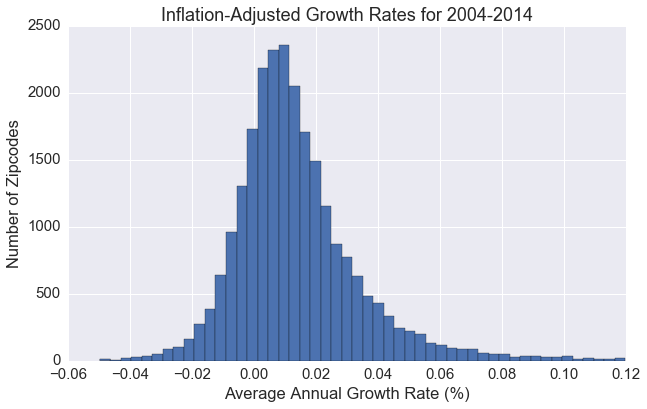

In [21]:
agi_data['growth_coef'][(agi_data['growth_coef']>-0.05) & (agi_data['growth_coef']<0.12)].hist(bins=50)
plt.title('Inflation-Adjusted Growth Rates for 2004-2014')
plt.xlabel('Average Annual Growth Rate (%)')
plt.ylabel('Number of Zipcodes')
plt.show()

## Predict Future Results

In [41]:
def collect_timeseries(feature):
    '''
    Returns a DataFrame that contains the timeseries data for a given feature.
    '''
    timeseries = {}
    for year in YEARS:
        timeseries[year] = normalized_data[year][feature].copy()
        timeseries[year].rename(feature+'Y'+year, inplace = True)
    timeseries = pd.concat(timeseries.values(), axis=1)
    columns = [feature+'Y'+year for year in YEARS]
    return timeseries[columns].dropna()

### Baseline Model

In [44]:
from sklearn.linear_model import LinearRegression

def make_baseline():
    '''
    Returns a numpy array containing the baseline model, which is just a linear regression for the current year
    based on all data from previous years.
    '''    
    data = collect_timeseries('agi_per_return').values
    baseline = np.zeros_like(data)
    for i,row in enumerate(data):
        for j in xrange(len(row)):
            if j == 0:
                continue
            model = LinearRegression()
            model.fit(np.arange(j).reshape(-1,1),row[:j].reshape(-1,1))
            baseline[i,j] = model.predict(j)
    #plt.plot(np.arange(5,16),aggregated)
    #plt.plot(np.arange(5,16).reshape(-1,1),baseline.predict(np.arange(5,16).reshape(-1,1)))
    #plt.show()
    #plt.plot(aggregated.reshape(-1,1) - baseline.predict(np.arange(11).reshape(-1,1)) )
    #plt.show()
    return baseline

### ML Model

#### Data prep

A number of functions which create pandas dataframes containing training and testing data.

In [42]:
def subtract_baseline():
    '''
    Computes the residuals of the baseline model. Results are in a DataFrame.
    '''
    timeseries_data = collect_timeseries('agi_per_return')
    return timeseries_data.sub(make_baseline())

In [43]:
def common_features():
    '''
    Returns a list of features which are present for all YEARS. These are the features we can use to build a model
    applicable over all of time.
    '''
    common = list(normalized_data['15'].drop(['agi_per_return', 'agi'], axis=1).columns)
    for year in YEARS:
        common = list(set(common).intersection(normalized_data[year].columns))
    return common

In [44]:
WINDOW = 2
FEATURES = [feature+'delta'+str(i) for feature in common_features() + ['agi_per_return'] for i in xrange(1,WINDOW+1)]
from collections import defaultdict
def training_data():
    '''
    Returns a dictionary which keys a year to a DataFrame containing all data for WINDOW number of previous years.
    This data is used to predict the result for that year.
    '''
    train_data_dict = defaultdict(pd.DataFrame)
    common = common_features()
    for feature in common + ['agi_per_return']:
        feature_data = collect_timeseries(feature)
        for i,year in enumerate(YEARS):
            prior_years = YEARS[:i]
            prior_features = [feature+'Y'+p_year for p_year in prior_years]
            num_years = len(prior_years)
            if num_years < WINDOW:
                continue
            for i in xrange(1,WINDOW+1):
                train_data_dict[year][feature+'delta'+str(i)] = feature_data[prior_features[-i]]
    #prior_years = YEARS
    #for feature in common + ['agi_per_return']:
    #    prior_features = [feature+'Y'+p_year for p_year in prior_years]
    #    feature_data = collect_timeseries(feature)
    #    for i in xrange(1,WINDOW+1):
    #        train_data_dict['last'][feature+'delta'+str(i)] = feature_data[prior_features[-i]]
    return train_data_dict

In [45]:
def make_model_target_data():
    '''
    Returns a pair of dictionaries. The first (model_data) keys a year to a DataFrame containing all of the training
    data for making predictions for that year (made up of raw data from prior years). The second (target_data) keys
    a year to a DataFrame containing the agi_per_return for that year and previous years. The model_data(year)
    DataFrame is the input to a ML model which predicts target_data(year).
    '''
    train_data = training_data()
    target = collect_timeseries('agi_per_return')
    model_data = {}
    target_data = {}
    for i,year in enumerate(YEARS[WINDOW:]):
        model_data[year] = pd.concat(tuple(train_data[year] for year in YEARS[WINDOW:i+1+WINDOW]), axis=0)[FEATURES]
        target_data[year] = pd.concat(tuple(target['agi_per_return'+'Y'+year] for year in YEARS[WINDOW:i+1+WINDOW]), axis=0)
    #model_data['all'] = pd.concat((model_data[YEARS[-1]],train_data['last']), axis=0)
    return model_data, target_data

In [129]:
%%time
model_data, target_data = make_model_target_data()

CPU times: user 281 ms, sys: 15.4 ms, total: 296 ms
Wall time: 288 ms


#### Model Construction

The actual model is made using sklearn.

In [134]:
from sklearn import base
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

class agi_estimator(base.BaseEstimator, base.RegressorMixin):
    '''
    The model has a linear piece and a nonlinear piece. The nonlinear piece is used to fit the residuals leftover
    from the linear piece.
    '''
    
    def __init__(self, alpha_lin = 0.5, alpha_res = 0.0001, activation = 'tanh', max_iter = 400,
                 n_hidden = 100,solver='adam'):
        self.linear_estimator = Lasso(alpha = alpha_lin)
        self.residual_estimator = MLPRegressor(alpha = alpha_res, activation = activation, max_iter=max_iter,
                                              hidden_layer_sizes=(n_hidden, ), solver=solver)
    
    def fit(self, X, y):
        self.linear_estimator.fit(X,y)
        self.coef_ = self.linear_estimator.coef_
        
        residuals = y - self.linear_estimator.predict(X)
        self.residual_estimator.fit(X, residuals)
        self.nlcoefs_ = self.residual_estimator.coefs_
        #print self.residual_estimator.n_iter_
        return self

    def predict(self, X):
        return self.linear_estimator.predict(X) + self.residual_estimator.predict(X)

#### Testing

In [36]:
def timeseries_CV():
    '''
    Does cross validation by splitting the data up by years. For a given year, all data for previous years is
    used for training. For testing, the model generated from that data is used to predict the next year's agi/return.
    CV is performed using predictions for all except the final year.
    '''
    if DIVISION == 'zipcode':
        num = 7759
    else:
        num = 51
    params = ['adam', 'lbfgs']
    CVscores = {}    
    for param in params:
        train_scores = {}
        test_scores = {}
        model = agi_estimator(solver = param)
        # year here represents a year we have data for, while YEARS[i+1+WINDOW] is the following year. We choose to
        # index out results by YEARS[i+1+WINDOW], since that is the year we are trying to predict.
        for i,year in enumerate(YEARS[WINDOW:-2]):
            if year in ['07','08', '09']:
                continue
            scaler = StandardScaler()
            model.fit(scaler.fit_transform(model_data[year]), target_data[year])
            train_scores[YEARS[i+1+WINDOW]] = model.score(scaler.transform(model_data[year]), target_data[year])
            test_scores[YEARS[i+1+WINDOW]] = model.score(scaler.transform(model_data[YEARS[i+1+WINDOW]].iloc[-num:]),\
                                            target_data[YEARS[i+1+WINDOW]].iloc[-num:])
        print sorted(train_scores.items())
        print sorted(test_scores.items())
        CVscores[param] = 1.*sum(test_scores.values())/len(test_scores)
    return CVscores

In [37]:
%%time
timeseries_CV()

[('11', 0.95612142130323952), ('12', 0.97771332197819205), ('13', 0.97262067917186001), ('14', 0.9774008607465442)]
[('11', 0.95956711382271875), ('12', 0.85681719232333697), ('13', 0.95881871079768133), ('14', 0.98932047839147708)]
[('11', 0.99990794689927653), ('12', 0.99996541241624282), ('13', 0.99993364744614099), ('14', 0.99982110317466866)]
[('11', 0.74334232945856171), ('12', 0.73585726083378189), ('13', 0.87565815850507533), ('14', 0.83607610106899066)]
CPU times: user 5.25 s, sys: 437 ms, total: 5.69 s
Wall time: 5.55 s


{'adam': 0.94113087383380356, 'lbfgs': 0.79773346246660237}

In [38]:
def final_score():
    '''
    Train the model on all data prior to the final available year, and test on data from the final year.
    '''
    model = agi_estimator()
    scaler = StandardScaler()
    model.fit(scaler.fit_transform(model_data[YEARS[-2]]), target_data[YEARS[-2]]) #Train using previus year's data.
    print model.score(scaler.transform(model_data[YEARS[-1]][-NUM_DIV:]), target_data[YEARS[-1]][-NUM_DIV:]) #Test on final year.

In [39]:
%%time
final_score()

0.970072941237
CPU times: user 186 ms, sys: 16.9 ms, total: 203 ms
Wall time: 193 ms


In [46]:
%%time
def baseline_score():
    '''
    Returns the baseline R^2 scores.
    '''
    data = collect_timeseries('agi_per_return')
    data_variance = ((data-data.mean())**2).mean()
    model_variance = (subtract_baseline()**2).mean()
    return (1-(model_variance/data_variance))[1:]
print baseline_score()

agi_per_returnY06    0.910319
agi_per_returnY07    0.846732
agi_per_returnY08    0.880204
agi_per_returnY09    0.871767
agi_per_returnY10    0.977261
agi_per_returnY11    0.976562
agi_per_returnY12    0.810125
agi_per_returnY13    0.972438
agi_per_returnY14    0.903728
agi_per_returnY15    0.911474
dtype: float64
CPU times: user 293 ms, sys: 11.1 ms, total: 304 ms
Wall time: 300 ms


#### Predictions

In [51]:
def train_model():
    '''
    Trains a model for each year in YEARS (as well as one beyond) using data from prior years.
    '''
    years = [year for year in YEARS[WINDOW+1:]] + ['16']
    models = {}
    scalers = {}
    for year in years:
        last_year = str(int(year)-1).zfill(2)
        models[year] = agi_estimator()
        scalers[year] = StandardScaler()
        models[year].fit(scalers[year].fit_transform(model_data[last_year]), target_data[last_year])
    return models, scalers

In [135]:
%%time
MODELS, SCALERS = train_model()

CPU times: user 3.65 s, sys: 252 ms, total: 3.9 s
Wall time: 3.83 s


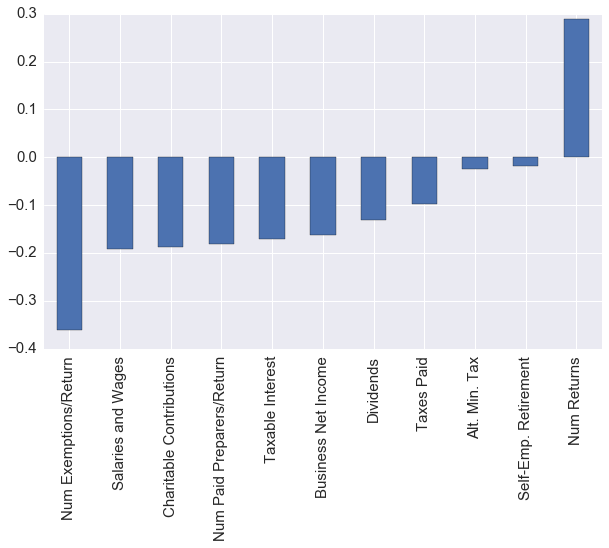

In [173]:
correlations = model_data['15'].corrwith(target_data['15'], axis=0)[:-2]
corr_feats = ['a09600', 'a18300','a19700', 'a00300','num_returns','a03300',
        'a00600', 'a00900', u'a00200',  'prep', 'num_exemp']
for feat in corr_feats:
    correlations[feat] = (correlations[feat+'delta1'] + correlations[feat+'delta2'])/2
rename_dict = {'a09600':'Alt. Min. Tax', 'a18300': 'Taxes Paid','a19700':'Charitable Contributions',
               'a00300':'Taxable Interest','num_returns': 'Num Returns','a03300':'Self-Emp. Retirement',
                'a00600':'Dividends', 'a00900':'Business Net Income', 'a00200':'Salaries and Wages',
               'prep':'Num Paid Preparers/Return', 'num_exemp': 'Num Exemptions/Return'}
correlations[corr_feats].rename(index = rename_dict).sort_values().plot(kind='bar');

In [185]:
correlations[corr_feats].rename(index = rename_dict).sort_values()

Num Exemptions/Return       -0.360422
Salaries and Wages          -0.192073
Charitable Contributions    -0.187848
Num Paid Preparers/Return   -0.180508
Taxable Interest            -0.170398
Business Net Income         -0.162572
Dividends                   -0.131588
Taxes Paid                  -0.097970
Alt. Min. Tax               -0.024059
Self-Emp. Retirement        -0.019093
Num Returns                  0.289507
dtype: float64

In [193]:
correlations[corr_feats].rename(index = rename_dict).sort_values().values

array([-0.36042159, -0.19207251, -0.18784825, -0.18050797, -0.17039812,
       -0.16257241, -0.13158836, -0.09797044, -0.0240594 , -0.01909347,
        0.28950671])

In [192]:
list(correlations[corr_feats].rename(index = rename_dict).sort_values().index)

['Num Exemptions/Return',
 'Salaries and Wages',
 'Charitable Contributions',
 'Num Paid Preparers/Return',
 'Taxable Interest',
 'Business Net Income',
 'Dividends',
 'Taxes Paid',
 'Alt. Min. Tax',
 'Self-Emp. Retirement',
 'Num Returns']

In [216]:
#correlations[corr_feats].rename(index = rename_dict).sort_values().to_csv('correlations')

In [53]:
def prediction(yr):
    '''
    Returns a prediction for yr using the model trained on data for all previous years.
    '''
    prior_years = [year for year in YEARS if int(yr) > int(year)]
    test_data = pd.DataFrame()
    common = common_features()
    for feature in common + ['agi_per_return']:
        prior_features = [feature+'Y'+p_year for p_year in prior_years]
        feature_data = collect_timeseries(feature)
        for i in xrange(1,WINDOW+1):
            test_data[feature+'delta'+str(i)] = feature_data[prior_features[-i]]
    test_data = test_data[FEATURES]
    return MODELS[yr].predict(SCALERS[yr].transform(test_data))

In [54]:
def predicted_agi():
    '''
    Creates a DataFrame containing the predictions of the model.
    '''
    results = pd.DataFrame()
    for year in YEARS[WINDOW+1:]+['16']:
        results['agi_per_returnY'+year] = prediction(year)
    results.index = normalized_data['15'].index
    return results

In [84]:
%%time
predicted_agi_df = predicted_agi()

ValueError: Length mismatch: Expected axis has 49 elements, new values have 51 elements

In [76]:
predicted_agi_df.head(10)

,agi_per_returnY08,agi_per_returnY09,agi_per_returnY10,agi_per_returnY11,agi_per_returnY12,agi_per_returnY13,agi_per_returnY14,agi_per_returnY15,agi_per_returnY16
state,,,,,,,,,
AK,46.089669,63.500229,61.535716,61.899007,62.220377,64.683601,67.138361,69.733128,73.118988
AL,39.566486,50.084622,46.643560,48.451331,48.838772,51.321410,54.533464,55.012229,57.234182
AR,32.387392,47.365499,45.785978,47.562625,48.082410,51.248067,54.428349,54.841031,57.250738
AZ,49.845864,58.575231,53.188159,53.962913,54.464761,58.018472,61.158859,60.868662,63.676510
CA,58.380449,64.656958,61.582847,63.205471,68.199565,74.334377,76.474716,77.424241,83.522290
CO,55.617427,66.873537,62.442798,62.306254,65.003093,69.222354,71.367239,73.227560,76.940201
CT,76.897665,85.332531,84.274308,83.385570,87.733951,94.036396,96.580993,95.404851,100.056714
DC,67.004527,80.306572,79.568714,77.919553,80.946007,87.071438,90.995261,90.590923,99.029088
DE,50.102770,61.039383,59.573602,57.739539,59.146018,62.063954,63.956030,65.064688,67.143343


In [57]:
diffs_df = pd.DataFrame()
observed_agi = collect_timeseries('agi_per_return')
observed_agi.index = normalized_data['15'].index
for year in YEARS[WINDOW+1:]:
    diffs_df[year] = predicted_agi_df['agi_per_returnY'+year].values - observed_agi['agi_per_returnY'+year].values
diffs_df.index = normalized_data['15'].index
diffs_df.head(10)

,08,09,10,11,12,13,14,15
state,,,,,,,,
AK,-9.892248,3.510246,0.459034,1.887423,-2.271595,-0.560378,-0.989133,-0.609578
AL,-6.471511,2.727290,-0.828922,-0.730744,-3.043413,-0.693911,0.718595,-1.039772
AR,-8.928305,-0.036487,-2.452848,-1.406725,-4.081742,-0.181068,0.266009,-1.064407
AZ,-1.439201,1.242720,0.197918,-0.004512,-2.538034,0.983843,1.329541,-1.377013
CA,-4.316923,5.038299,-2.704858,-3.385386,-5.060500,2.688024,-0.312734,-3.807402
CO,-4.118724,3.595150,-1.549156,-2.090711,-3.999715,1.292529,-1.711812,-1.568961
CT,-4.590573,5.758100,-4.034499,-1.902075,-5.325192,4.228655,1.277630,-1.390868
DC,-3.114831,6.120173,1.681344,-0.878125,-6.012834,2.848502,0.182500,-4.548646
DE,-2.929732,1.644371,1.461261,-0.242093,-2.250804,1.323208,0.442761,0.075064


In [58]:
np.abs(diffs_df).describe()

,08,09,10,11,12,13,14,15
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,6.490090,2.540382,1.355900,1.189867,3.184849,1.397356,0.822405,1.245662
std,4.747944,2.145021,1.121966,1.041546,1.565957,1.089502,0.842239,0.993579
min,0.043231,0.036487,0.037454,0.004512,0.124372,0.032017,0.001519,0.028002
25%,4.282882,0.870148,0.461196,0.355264,2.315591,0.778751,0.236684,0.462259
50%,6.115551,1.906304,1.140492,0.982698,2.916498,1.127164,0.673789,1.064407
75%,7.859412,3.552698,2.007015,1.876149,4.128720,1.517636,1.163189,1.659058
max,34.263599,10.360221,4.579790,4.745761,8.844297,4.629408,5.002395,4.548646


In [1642]:
(collect_timeseries('agi_per_return')-subtract_baseline()).mean().values[1:]

array([ 52.07796951,  57.08331162,  54.70034598,  56.24606958,
        55.73834944,  56.85311175,  57.74973157,  60.38681621,
        61.75509152,  63.93123908])

In [1644]:
%%time
mean_sq = [(int(year),
            ((prediction(year)-collect_timeseries('agi_per_return')['agi_per_returnY'+year].values)**2).mean())
            for year in YEARS[WINDOW+1:]]

CPU times: user 3.22 s, sys: 153 ms, total: 3.37 s
Wall time: 3.36 s


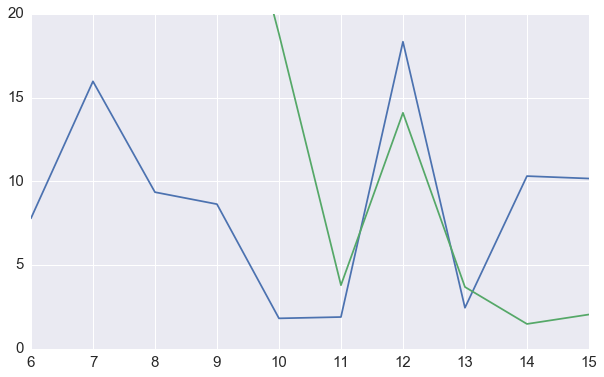

In [1717]:
plt.plot(range(6,16), (subtract_baseline()**2).mean().values[1:]);
plt.plot(zip(*mean_sq)[0],zip(*mean_sq)[1]);
plt.ylim([0,20]);
plt.show()

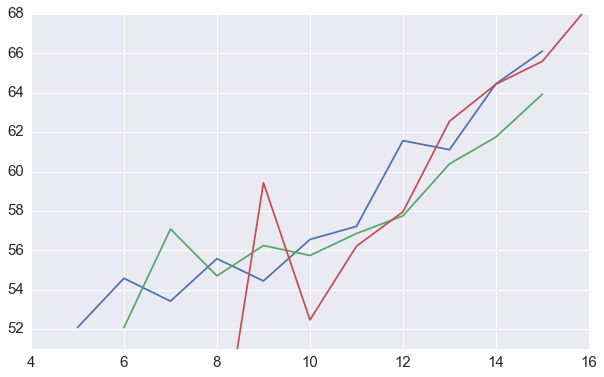

In [1718]:
plt.plot(range(5,16), collect_timeseries('agi_per_return').mean().values);
plt.plot(range(6,16), (collect_timeseries('agi_per_return')-subtract_baseline()).mean().values[1:]);
plt.plot(zip(*predictions)[0],zip(*predictions)[1]);
plt.ylim([51,68]);

## Visualizations

* A heat map of the average growth rates, shaded zipcode by zipcode.

* The middle of the country has the best growth rates!

### Bokeh Plots

In [71]:
predicted_agi_df = predicted_agi()
predicted_agi_df.index = normalized_data['15'].index
observed_agi = collect_timeseries('agi_per_return')
observed_agi.index = normalized_data['15'].index
#predicted_agi_df.to_csv('predicted_agi_per_return_all')
#observed_agi.to_csv('observed_agi_per_return_all')

In [60]:
observed_data.head()

NameError: name 'observed_data' is not defined

In [63]:
import itertools
import pandas as pd
from collections import OrderedDict

from bokeh.io import output_file, reset_output
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.embed import components
from bokeh.layouts import widgetbox, column
from bokeh.models import CustomJS,HoverTool
from bokeh.models.widgets import Dropdown, CheckboxButtonGroup
reset_output()
output_notebook()

#import seaborn as sns

import state_abbr


observed_data = pd.read_csv('observed_agi_per_return_all',index_col = 0).transpose()
observed_data['x'] = [5,6,7,8,9,10,11,12,13,14,15]
predicted_data = pd.read_csv('predicted_agi_per_return_all',index_col = 0).transpose()
predicted_data['x'] = [8,9,10,11,12,13,14,15,16]

pred_source = ColumnDataSource(predicted_data)
obs_source = ColumnDataSource(observed_data)
    
# define the color palette
#ncolors = 5
#palette = sns.palettes.color_palette('colorblind', ncolors)
# as_hex is necessary for bokeh to render the colors properly.
#colors = itertools.cycle(palette.as_hex())
colors = itertools.cycle([u'#0072b2', u'#009e73', u'#d55e00', u'#cc79a7', u'#f0e442'])

states_abbr = ['IN', 'MA']

plot = figure(plot_width=400, plot_height=400,\
     title = 'Adjusted Gross Income per Return',
     x_axis_label = 'Year',
     y_axis_label = 'AGI/Return ($ thousands)')



pred_plots = []
obs_plots = []

#_tools_to_show = 'box_zoom,pan,save,hover,reset,tap,wheel_zoom'
#plot  = figure(width=800, height=600, tools=_tools_to_show)
for state, color in itertools.izip(states_abbr, colors):
    pred_plots.append(plot.line('x',state, source = pred_source,line_width=3, legend = dict(value = state),\
                  line_color = color,line_dash="4 4"))
    obs_plots.append(plot.line('x', state, source = obs_source,line_width=3,line_color = color,legend = dict(value = state)))
plot.legend.location = 'top_left'


checkbox_button_group = CheckboxButtonGroup(
        labels=["Recorded Data", "Predictions"], active=[0, 1])


args = {'predicted' + str(i) : pred_plots[i] for i in xrange(len(pred_plots))}
args.update({'observed' + str(i) : obs_plots[i] for i in xrange(len(obs_plots))})
args['checkbox_button_group']=checkbox_button_group

code = ""
for i in xrange(len(obs_plots)):
    code += "predicted"+ str(i)+".visible = checkbox_button_group.active.includes(1); \n"
    code += "observed"+ str(i)+".visible = checkbox_button_group.active.includes(0); \n"

checkbox_button_group.callback = CustomJS(args=args, code=code)


#checkbox_button_group.on_change
#hover=plot.select(dict(type=HoverTool))
#hover.tooltips = OrderedDict([
#    ("AGI/Return", "$y")
#])
#hover.mode = 'mouse'

#layout = widgetbox(dropdown) 
layout = column(plot,checkbox_button_group)

#output_file("projectwebpage.html", title="projectwebpage") 
show(layout)

Loading BokehJS ...

In [218]:
from bokeh.palettes import PuBu
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, ranges, LabelSet
from bokeh.plotting import figure
output_notebook()


correlations = pd.read_csv('correlations',index_col = 0)

source = ColumnDataSource(dict(x = list(correlations.index), 
                              y =list(correlations.values)))

x_label = "Feature"
y_label = "Correlation Coefficient"
title = "Features Correlated with AGI/Return"
plot = figure(plot_width=600, plot_height=600, tools="save",
        x_axis_label = x_label,
        y_axis_label = y_label,
        title=title,
        x_minor_ticks=2,
        x_range = source.data["x"],
        y_range= ranges.Range1d(start=-0.4,end=0.3))


#labels = LabelSet(x='x', y='y', text='y', level='glyph',
#        x_offset=-13.5, y_offset=0, source=source, render_mode='canvas')

plot.vbar(source=source,x='x',top='y',bottom=0,width=0.3, color=PuBu[7][2])
plot.xaxis.major_label_orientation = np.pi/3

#plot.add_layout(labels)
show(plot)

Loading BokehJS ...

### Maps

In [297]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import shapefile as shp

In [305]:
sf = shp.Reader('cb_2016_us_state_500k/cb_2016_us_state_500k')
shapes = sf.shapes()
records = sf.records()
states = [record[4] for record in records]

In [35]:
sf = shp.Reader('cb_2014_us_zcta510_500k/cb_2014_us_zcta510_500k')
shapes = sf.shapes()
records = sf.records()
zipcodes = [int(record[0]) for record in records]

In [ ]:
plot_data = agi_data['growth_coef'][(agi_data['growth_coef']>-0.05) & (agi_data['growth_coef']<0.12)]

In [328]:
def draw_map(map_data, min_quant, max_quant, cbar = False, regions = 'states'):

    #map_min = map_data.quantile(min_quant)
    #map_max = map_data.quantile(max_quant)
    map_min = 30
    map_max = 80
    map_norm = map_max - map_min

    if cbar == False:
        map_data = map_data[(map_data < map_max) & (map_data > map_min)].dropna()


    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    #cmap = plt.cm.Reds
    #cmap = plt.cm.coolwarm
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.cubehelix_palette(8, as_cmap = True)

    
    my_map = Basemap(projection='lcc', lat_0=57, lon_0=-95, resolution = 'l',\
        llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,lat_1=33,lat_2=45)
 
    my_map.drawcoastlines()
    my_map.drawcountries()
    #my_map.fillcontinents(color='coral')
    my_map.drawmapboundary()
    #my_map.drawmeridians(np.arange(0, 360, 30))
    #my_map.drawparallels(np.arange(-90, 90, 30))
    
    
    for i, value in enumerate(map_data):
        region_id = map_data.index[i]
        if cbar:
            fc = cmap((value-map_min)/map_norm)
        else:
            fc = 'red'
            
        shape = shapes[states.index(region_id)]
        lons,lats = zip(*shape.points)
        x, y = my_map( lons, lats )
        xy = zip(x,y)
        poly = Polygon( xy, facecolor=fc, edgecolor = fc, alpha=1 )
        plt.gca().add_patch(poly)
    
    '''
    for record, shape in zip(records,shapes):
        zipcode = int(record[0])
        try:
            value = map_data.loc[zipcode]
            if cbar:
                fc = cmap((value-map_min)/map_norm)
            else:
                fc = 'red'
        except KeyError:
            fc = 'none'
        lons,lats = zip(*shape.points)
        x, y = my_map( lons, lats )
        xy = zip(x,y)
        poly = Polygon( xy, facecolor=fc, edgecolor = fc, alpha=1 )
        plt.gca().add_patch(poly)  
    '''        
    if cbar:
        plt.title('States Shaded by AGI/Return')
    else:
        plt.title('Zipcodes Having AGI per Exemption Between \$ {0:.0f}k and \$ {1:.0f}k'.format(map_min, map_max))

    if cbar:
        cax = plt.gcf().add_axes([0.95, 0.2, 0.02, 0.6])
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional',ticks=[0, 0.5, 1])
        cb.set_label('AGI/Return (\$ thousands)')
        cb.ax.set_yticklabels(['<{:.0f}'.format(map_min),\
                               '{:.0f}'.format((map_min+map_max)/2),'>{:.0f}'.format(map_max)])
    
    
    plt.show()

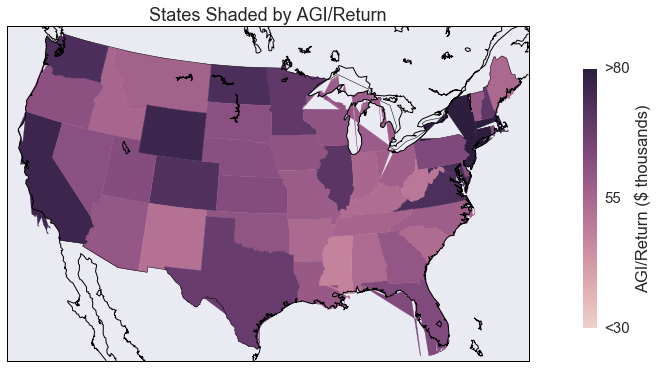

In [329]:
draw_map(normalized_data['14'].dropna().agi_per_return,.1,.9, True)

In [20]:
plot_data = agi_data['growth_coef'][(agi_data['growth_coef']>-0.05) & (agi_data['growth_coef']<0.12)]

/Users/stefan/anaconda/lib/python2.7/site-packages/seaborn/palettes.py:725: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
/Users/stefan/anaconda/lib/python2.7/site-packages/seaborn/palettes.py:725: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


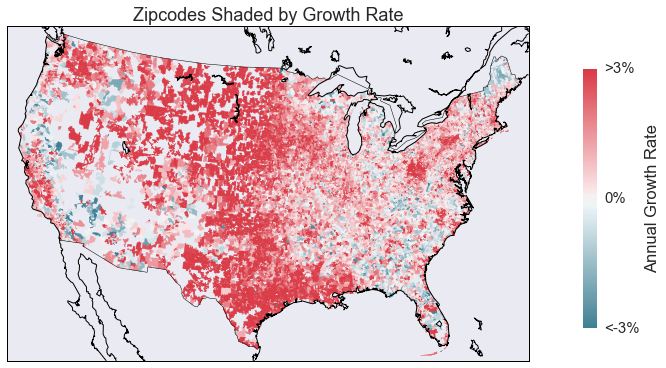

In [40]:
draw_map(plot_data,.1,.9, True)

## Score Regions Based on User-Defined Features

* Take User-Defined Score (Based on User-Defined Priorities)

* Compute Predictor for User-Defined Score Using Other Variables

* Display Top/Bottom Regions for the Score and WHY the Model Scored Them That Way (Weights and Categories)

First we make a list of all the features which involve counts of numbers of returns (number_features) and a list of all the features which involve dollar amounts (amount_features).

Create normalized features.

* Target : the thing we are trying to optimize. should be some sort of weighted average of income 

* Restrctions : limit to a subset of the data. Based on geography or demographics

* Model : fit target using data (subject to restrictions). find important features and report them.

In [245]:
def drop_uncorrelated(threshold):
    for year in years: 
        uncorr_features = \
        normalized_data[year].columns[pd.Series.abs(normalized_data[year].corr().agi_per_return) < threshold]
        normalized_data[year]=normalized_data[year].drop(uncorr_features,axis=1)
drop_uncorrelated(.25)

{'alpha': 0.060000000000000005}


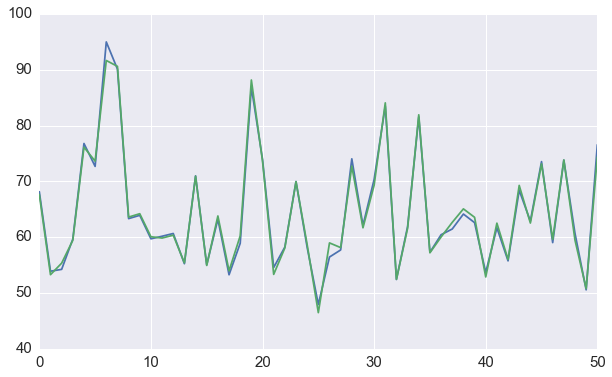

CPU times: user 767 ms, sys: 60.9 ms, total: 828 ms
Wall time: 891 ms


In [267]:
%%time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.linear_model import Lasso

X = normalized_data['14'].dropna().copy()
X = X.drop('agi_per_return', axis=1)
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
Y = normalized_data['14'].dropna().agi_per_return

mod = Lasso(alpha=.06)

gs = sklearn.model_selection.GridSearchCV(
    mod,
    {"alpha": np.arange(.01,.2,.01)},
    cv=3,  # 3-fold cross validation
    n_jobs=1,  # run each hyperparameter in one of two parallel jobs
)
gs.fit(X, Y)
print gs.best_params_

plt.plot(pd.Series.rolling(pd.Series(Y.values), window=1).mean())
plt.plot(pd.Series.rolling(pd.Series(gs.predict(X)), window=1).mean())
plt.show()

In [280]:
mod.fit(X,Y)

Lasso(alpha=0.06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [283]:
normalized_data['14'].columns[mod.coef_ != 0]

Index([u'mars2', u'agi', u'n00300', u'n00600', u'a00600', u'a01400', u'a01700',
       u'n02500', u'n03220', u'a03220', u'n03300', u'n03210', u'n18500',
       u'a05780', u'a07300', u'n07180', u'a07240', u'n09400', u'n09750',
       u'% w/ Investments', u'Investment Income/AGI', u'n11901'],
      dtype='object')

In [294]:
sorted(zip(mod.coef_, normalized_data['14'].columns), key = lambda x: np.abs(abs(x[0])), reverse = True)[:5]

[(3.7382327328747045, '% w/ Investments'),
 (2.1339656931442645, 'Investment Income/AGI'),
 (-2.0053588494252046, 'a07240'),
 (1.5006952326444782, 'n03220'),
 (-1.4679689100742508, 'a03220')]

The most important features are
1. the fraction of returns with investement income
2. the fraction of AGI coming from wages
3. the fraction of single returns (as opposed to joint or head-of-household)
4. the number of dependents per return

To look at these features in greater depth, we analyze their correlations with each other and with AGI per Exemption. That is done in the following plots:

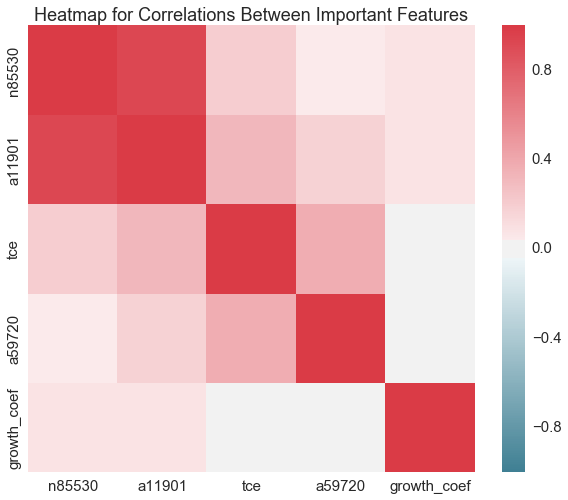

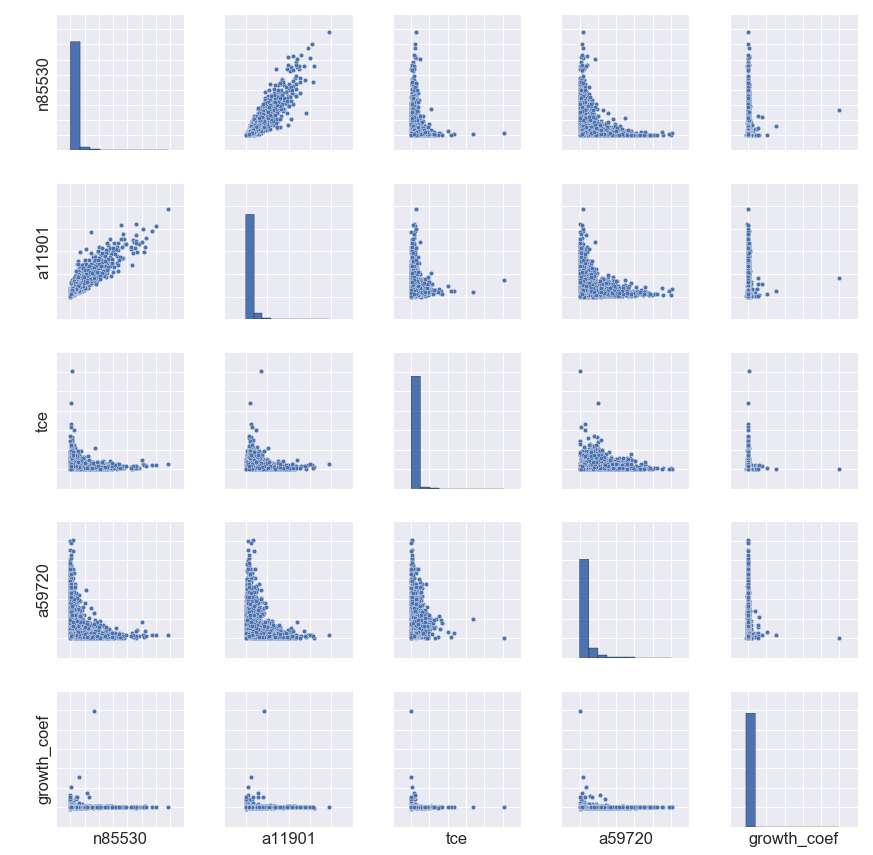

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

imp_features = ['n85530', 'a11901', 'tce', 'a59720', 'a06500']
f, ax = plt.subplots(figsize=(10, 8))
corr = model_df[imp_features[:4] + ['growth_coef']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Heatmap for Correlations Between Important Features')
plt.show()
pp = sns.pairplot( model_df[imp_features[:4] + ['growth_coef']])
for i in range(5):
    plt.setp(pp.axes[i,0].get_yticklabels(), visible=False)
    plt.setp(pp.axes[4,i].get_xticklabels(), visible=False)
plt.show()

* % w/Investements has the highest correlation coefficient with AGI/Exemption out of all features at 0.85.
* Wages/AGI has the largest-in-magnitude negative correlation at -0.41
* % Single and Dependents/Return are well-correlated with each other and have moderate correlations with AGI/Exemption.
    * Perhaps their combined effect is useful for the model?

In [425]:
model_df.drop(['A05800', 'A04800', 'N04800', 'N05800', 'A06500', 'N06500',\
            'A10300', 'N10300', 'A11902', 'N11902', 'A10600', 'N10600', 'A59660', 'N59660', 'A59720', 'N59720',\
                  'N11070', 'A11070', 'A07220', 'N07220', 'A02650', 'N02650', 'A00101']\
              ,axis=1).corr()['AGI/Exemption'].sort_values()

Wages/AGI               -0.417463
A07240                  -0.347077
MARS4                   -0.284305
N07240                  -0.284098
Dependents/Return       -0.275193
A09750                  -0.273591
Total Credits/AGI       -0.255051
Exemptions per Return   -0.253412
A01700                  -0.247826
A02300                  -0.213330
N09750                  -0.208677
A10960                  -0.206399
% w/ Wages              -0.201249
A07230                  -0.189273
SS Benefits/AGI         -0.175415
A85775                  -0.132039
A85770                  -0.131399
N02300                  -0.131045
SCHF                    -0.124864
A03210                  -0.122230
A07180                  -0.109196
A03220                  -0.079168
A05780                  -0.051240
N10960                  -0.041112
A11560                  -0.036917
A09400                  -0.011743
N85770                   0.003635
A07260                   0.010560
A03230                   0.015165
N85775        

In [462]:
test = data[year].groupby('zipcode').sum()[['num_returns', 'num_exemp', 'agi']]
test['agi_per_exemp'] = test.agi/test.num_exemp
test[test['agi_per_exemp'] > 128].sum()/test.sum()

num_returns      0.007320
num_exemp        0.006445
agi              0.037583
agi_per_exemp    0.068800
dtype: float64

In [465]:
test[test['agi_per_exemp'] > 1200]

,num_returns,num_exemp,agi,agi_per_exemp
zipcode,,,,
33109,240.0,470.0,585911.0,1246.619149


## Convert to Slides

In [114]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)
import os
os.system('jupyter-nbconvert --to slides DataINcubatorProjectv3.ipynb --reveal-prefix=reveal.js')

0